## Assignment - Recommendation Systems

### Objective
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

### Context
Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time

### Data Description
Amazon Reviews data (​data source​) The repository has several datasets. For this case study, we are using the Electronics dataset.

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import scipy.sparse
from scipy.sparse import csr_matrix
import warnings
%matplotlib inline

In [2]:
Col_Header = ['userId','productId','Rating','timestamp']

df = pd.read_csv('ratings_Electronics.csv', names = Col_Header)

In [3]:
df.head(5)

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


### Attribute Information

● userId : Every user identified with a unique id <br/>
● productId : Every product identified with a unique id <br/>
● Rating : Rating of the corresponding product by the corresponding user <br/>
● timestamp : Time of the rating (ignoring this column for this exercise) <br/>

In [4]:
df.drop(['timestamp'],axis=1,inplace =True)

In [5]:
df.head(5)

,userId,productId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [6]:
df.shape

(7824482, 3)

In [7]:
df.dtypes

userId        object
productId     object
Rating       float64
dtype: object

In [8]:
df.isnull().sum()

userId       0
productId    0
Rating       0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
userId       object
productId    object
Rating       float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rating,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


In [11]:
df["Rating"].value_counts()

5.0    4347541
4.0    1485781
1.0     901765
3.0     633073
2.0     456322
Name: Rating, dtype: int64

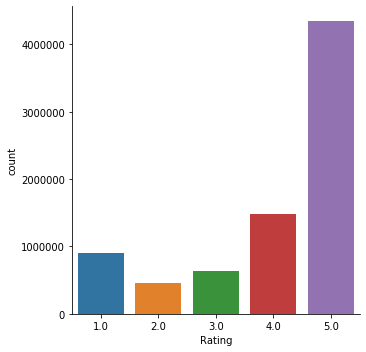

In [12]:
sns.catplot(x = "Rating", data=df, kind='count')

### Observations

1. Neither null values nor missing values were spotted
2. Spread of the column 'Rating' is not balanced, 5 rating is maximum in count

In [13]:
# Creating a subset, such a way the users only who has given 50 or more number of ratings are considered

base = df['userId'].value_counts()
df_final = df[df['userId'].isin(base[base >= 50].index)]

df_final.shape

(125871, 3)

In [14]:
print("Total number of users:", df['userId'].count())
print("Total number of users who has given >=50 ratings:", df_final['userId'].count())

Total number of users: 7824482
Total number of users who has given >=50 ratings: 125871


In [15]:
df_final.head(5)

,userId,productId,Rating
94,A3BY5KCNQZXV5U,0594451647,5.0
118,AT09WGFUM934H,0594481813,3.0
177,A32HSNCNPRUMTR,0970407998,1.0
178,A17HMM1M7T9PJ1,0970407998,4.0
492,A3CLWR1UUZT6TG,0972683275,5.0


In [16]:
# Spliting the data randomly into train and test dataset

train_data, test_data = train_test_split(df_final, test_size = 0.3, random_state=7)

In [17]:
# Count of user_id for each unique product as recommendation point

train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'Points'},inplace=True)

train_data_grouped.head()

,productId,Points
0,0594451647,1
1,0594481813,1
2,0970407998,2
3,0972683275,4
4,1400501466,6


In [18]:
# Sort the products on recommendation points

train_data_sort = train_data_grouped.sort_values(['Points', 'productId'], ascending = [0,1]) 
      
# Generate a recommendation rank based upon points 

train_data_sort['Rank'] = train_data_sort['Points'].rank(ascending=0, method='first') 

In [19]:
# The top 10 recommendations 

popularity_recommendations = train_data_sort.head(10) 
popularity_recommendations 

,productId,Points,Rank
30877,B0088CJT4U,146,1.0
19628,B003ES5ZUU,128,2.0
30281,B007WTAJTO,114,3.0
8677,B000N99BBC,107,4.0
31132,B008DWCRQW,105,5.0
30572,B00829TIEK,103,6.0
30568,B00829THK0,100,7.0
17337,B002R5AM7C,98,8.0
22768,B004CLYEDC,84,9.0
17734,B002V88HFE,78,10.0


In [20]:
# Popularity based recommender model to make predictions

def pop_Recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated
    
    user_recommendations['userId'] = user_id 
      
    #Bring user_id column to the front
    
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations 

In [21]:
sample_Input = [12,345,6789]

for i in sample_Input:
    print("Top 10 recommendations for the userId: %d\n" %(i))
    print(pop_Recommend(i))    
    print("\n") 

Top 10 recommendations for the userId: 12

       userId   productId  Points  Rank
30877      12  B0088CJT4U     146   1.0
19628      12  B003ES5ZUU     128   2.0
30281      12  B007WTAJTO     114   3.0
8677       12  B000N99BBC     107   4.0
31132      12  B008DWCRQW     105   5.0
30572      12  B00829TIEK     103   6.0
30568      12  B00829THK0     100   7.0
17337      12  B002R5AM7C      98   8.0
22768      12  B004CLYEDC      84   9.0
17734      12  B002V88HFE      78  10.0


Top 10 recommendations for the userId: 345

       userId   productId  Points  Rank
30877     345  B0088CJT4U     146   1.0
19628     345  B003ES5ZUU     128   2.0
30281     345  B007WTAJTO     114   3.0
8677      345  B000N99BBC     107   4.0
31132     345  B008DWCRQW     105   5.0
30572     345  B00829TIEK     103   6.0
30568     345  B00829THK0     100   7.0
17337     345  B002R5AM7C      98   8.0
22768     345  B004CLYEDC      84   9.0
17734     345  B002V88HFE      78  10.0


Top 10 recommendations for th

### Inference

1. Popularity based recommendation - Recommendation list remains same for evey userID
2. Not a personalized recommendation engine,  not based on user preference

In [22]:
pivot_df = df_final.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.set_index(['user_index'], inplace=True)
pivot_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
pivot_df.shape

(1540, 48190)

In [24]:
# Singular Value Decomposition

from scipy.sparse.linalg import svds

U, sigma, Vt = svds(pivot_df, k = 10)
sigma = np.diag(sigma)

In [25]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Predicted ratings

pred_df = pd.DataFrame(predicted_ratings, columns = pivot_df.columns)
pred_df.head()

productId,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.002661,0.003576,0.004050,0.006906,0.003967,0.003073,0.005782,0.000568,0.014386,0.002708,...,6.108890e-04,0.044224,0.002919,0.060347,-0.002137,0.006751,0.001525,0.130951,0.059243,0.015014
1,0.002262,0.002505,0.005136,0.016517,0.007120,0.001438,0.013258,0.000335,-0.003781,0.001190,...,2.024793e-04,0.029213,0.000010,0.000244,-0.003111,-0.000621,0.004409,-0.039241,-0.006889,0.003696
2,-0.001600,-0.002502,0.002186,0.016742,0.006716,-0.002113,0.005805,0.003497,-0.005009,-0.001588,...,-3.240446e-04,0.009180,-0.002459,-0.016922,0.019936,-0.002483,-0.000155,-0.002889,-0.011522,-0.004525
3,0.002732,0.003867,0.001799,0.009395,0.004075,0.002778,0.003507,0.000095,0.007983,0.002381,...,6.031462e-04,-0.003369,0.003433,-0.003428,-0.000750,0.000119,0.002612,-0.015107,-0.006740,0.003276
4,0.000704,0.000085,0.002051,0.009664,0.004438,0.000335,0.005992,0.001056,-0.000369,0.000373,...,3.745108e-08,-0.001140,-0.000323,-0.025215,0.004700,-0.002170,0.001263,-0.048555,-0.016301,-0.003377


In [26]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, pred_df, num_recommendations):
      
    user_idx = userID-1
    
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    
    #sorted_user_ratings
    sorted_user_predictions = pred_df.iloc[user_idx].sort_values(ascending=False)
    
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\n Recommendations for userID = {}:\n'.format(userID))
    print(temp.head(num_recommendations))

In [27]:
# Evaluating collaborative model filtering SVD based 

final_ratings_matrix = df_final.pivot(index = 'userId', columns ='productId', values = 'Rating').fillna(0)
print('Shape of (final_ratings_matrix): ', final_ratings_matrix.shape)
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('Total number of ratings: ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('Number of ratings possible: ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('Density: {:4.2f}%'.format(density))

Shape of (final_ratings_matrix):  (1540, 48190)
Total number of ratings:  125871
Number of ratings possible:  74212600
Density: 0.17%


In [28]:
rmse_df = pd.concat([final_ratings_matrix.mean(), pred_df.mean()], axis=1)

rmse_df.columns = ['avg_actual_ratings', 'avg_predicted_ratings']
print(rmse_df.shape)

rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,avg_actual_ratings,avg_predicted_ratings,item_index
productId,,,
0594451647,0.003247,0.001542,0
0594481813,0.001948,0.002341,1
0970407998,0.003247,0.002597,2
0972683275,0.012338,0.011807,3
1400501466,0.012987,0.004848,4


In [29]:
RMSE = round((((rmse_df.avg_actual_ratings - rmse_df.avg_predicted_ratings) ** 2).mean() ** 0.5), 5)

print('\nRMSE value for SVD Model = {} \n'.format(RMSE))


RMSE value for SVD Model = 0.0033 



### Top 5 recommendations for different users - Popularity based

In [30]:
popularity_recommendations = train_data_sort.head(5)

sample_Input = [23,65]

for i in sample_Input:
    print("Top 5 recommendations for the userId: %d\n" %(i))
    print(pop_Recommend(i))    
    print("\n") 

Top 5 recommendations for the userId: 23

       userId   productId  Points  Rank
30877      23  B0088CJT4U     146   1.0
19628      23  B003ES5ZUU     128   2.0
30281      23  B007WTAJTO     114   3.0
8677       23  B000N99BBC     107   4.0
31132      23  B008DWCRQW     105   5.0


Top 5 recommendations for the userId: 65

       userId   productId  Points  Rank
30877      65  B0088CJT4U     146   1.0
19628      65  B003ES5ZUU     128   2.0
30281      65  B007WTAJTO     114   3.0
8677       65  B000N99BBC     107   4.0
31132      65  B008DWCRQW     105   5.0




### Top 5 recommendations for different users - Collaborative

In [31]:
userID = 23
num_recommendations = 5
recommend_items(userID, pivot_df, pred_df, num_recommendations)


 Recommendations for userID = 23:

                   user_ratings  user_predictions
Recommended Items                                
B0079UAT0A                  0.0          5.546958
B004CLYEFK                  0.0          4.393817
B008X9Z7N0                  0.0          3.757475
B008X9Z8NE                  0.0          3.702200
B005QCDY50                  0.0          3.363602


In [32]:
userID = 65
num_recommendations = 5
recommend_items(userID, pivot_df, pred_df, num_recommendations)


 Recommendations for userID = 65:

                   user_ratings  user_predictions
Recommended Items                                
B007WTAJTO                  0.0          0.664513
B003ES5ZUU                  0.0          0.526901
B002V88HFE                  0.0          0.415989
B002WE6D44                  0.0          0.316005
B001TH7GUU                  0.0          0.296098


### Summary

1. The Popularity-based recommender system is not personalised to any conditions and the recommendations are based on frequecy counts generically, which may be not suitable to the user. 

2. Collaborative Filtering is a personalised recommender system, the recommendations are based on the past behavior of the user and it is not dependent on any other additional information.

3. The Popularity based model has recommended the same set of recommendations to both users but Collaborative Filtering based model has recommended entirely different list based on the user's past history.